In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import requests
import json

import os
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

import boto3

from IPython.core.display import HTML, display

/tmp/ipykernel_537520/2216088847.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


# Lecture 4a - JSONs and APIs
by Vítek Macháček
October 25, 2022

### Contents

* Standardized data representation
* JSON (+ XMLs)
* Introduction to Requests (GET vs. POST) and APIs


### Goals:
    
* work with data  online/real-time data
* acquisition, processing - > results
* Today introduction and next week a practical example

## Microservice architecture

* Foundation of modern software architecture
* Do one thing and do it well.

![Microservice architecture schema](./img/microservice-architecture.png "Microservice Architecture")


## Date exchange formats - JSON, XML

`Language of the internet`

* You can send/receive a message with (almost) any service
* we need system agnostic data format 
* is ediatable in basic editors
* More complex than simple tables
* Highly structured - if you dont follow the rules, you are out
* Both sides need to understand the structure
* only data. It does not do anything - no code to be run
* distributed as text/string (to be precise as `bytes` literals) 
* parsed to objects - easy to work with straight away
* Can be persisted as special files, or some data streams from APIs. 
* Human readable
* Hierarchical
* Can be fetched using standard web APIs

### Purpose

1. Communication 
    * All imaginable communication channels
    * Applications

2. Storing
    * self-descriptive
    * human readable
    * also in DBs - SQL, MongoDB etc.

3. Standardization
    * predictability
    * cooperation
    * spillovers from standardization

### Dimensionality problem

* rich information comes at costs of data complexity 
* to interrelate information, you need to high dimensionality (or A LOT of columns)
* Strongly object-oriented


### 1D:
* logs

### 2D
* tabular data (like pandas DFs)
* SQL

### 3+D:
#### XML (and HTML)
* eXtensible Markup Language is a software- and hardware-independent tool for storing and transporting data.
* Officialy defined at 1998, but its roots are even older.
* XML was designed to carry data - with focus on what data is
* HTML was designed to display data - with focus on what data should look like displayed
* XML tags are not predefined like HTML tags are
* more verbose than JSON
* can have comments !actually a really cool in useful feature!
* used historically as a transaction format in many areas: 
    * Scientific measurements
    * News information
    * Wheather measurements
    * Financial transactions
* Necessary to use XML parser - for example `BeautifulSoup` or `xmltree`
* doc`x`, xls`x`, etc. stands for xml


### JSON
* JavaScript Object Notation
* often *.json* files
* but also used in the web etc.
* supports standard datatypes - strings, integers, floats, lists
* No comments
* More compact, less verbose
* No closing tags
* Used EVERYWHERE, BUT [NOT LICENSED FOR EVIL](https://www.json.org/license.html). If you want to do evil stuff, use XML instead.
* Native in JavaScript and close to native in Python (dictionary)
* Jupyter Notebooks

# JSON

* JSON is similar to combination of `dictionaries` (`object` in JSON-terms)  and `lists` (`arrays`) in Python

In [2]:
teachers = [
    {'name':'Jozef Baruník','titles':['doc.','PhDr.','Ph.D.','Bc.','Mgr.'],'ID':1234,'courses':['JEM005','JEM116','JEM059','JEM061']},
    {'name':'Martin Hronec','titles':['Bc.','Mgr.'],'ID':3421,'courses':['JEM005','JEM207']},
]

courses = {
    "JEM005":{'name':'Advanced Econometrics','ECTS':6,'teachers':[3421,1234]},
    'JEM207':{'name':'Data Processing in Python','ECTS':5,'teachers':[3421]},
    'JEM116':{'name':'Applied Econometrics','ECTS':6,'teachers':[1234]},
    'JEM059':{'name':'Quantitative Finance I.','ECTS':6,'teachers':[1234,5678]},
    'JEM061':{'name':'Quantitative Finance II.','ECTS':6,'teachers':[1234,5678]}
}
jsondata = {'teachers':teachers,'courses':courses}
jsondata

{'teachers': [{'name': 'Jozef Baruník',
   'titles': ['doc.', 'PhDr.', 'Ph.D.', 'Bc.', 'Mgr.'],
   'ID': 1234,
   'courses': ['JEM005', 'JEM116', 'JEM059', 'JEM061']},
  {'name': 'Martin Hronec',
   'titles': ['Bc.', 'Mgr.'],
   'ID': 3421,
   'courses': ['JEM005', 'JEM207']}],
 'courses': {'JEM005': {'name': 'Advanced Econometrics',
   'ECTS': 6,
   'teachers': [3421, 1234]},
  'JEM207': {'name': 'Data Processing in Python',
   'ECTS': 5,
   'teachers': [3421]},
  'JEM116': {'name': 'Applied Econometrics', 'ECTS': 6, 'teachers': [1234]},
  'JEM059': {'name': 'Quantitative Finance I.',
   'ECTS': 6,
   'teachers': [1234, 5678]},
  'JEM061': {'name': 'Quantitative Finance II.',
   'ECTS': 6,
   'teachers': [1234, 5678]}}}

is this a valid JSON?

https://jsonformatter.curiousconcept.com/

![python and JSON](./img/python_json.png)

In [3]:
js = json.dumps(
    jsondata, indent=4, ensure_ascii = False
) #json formatted string!

print(js)

{
    "teachers": [
        {
            "name": "Jozef Baruník",
            "titles": [
                "doc.",
                "PhDr.",
                "Ph.D.",
                "Bc.",
                "Mgr."
            ],
            "ID": 1234,
            "courses": [
                "JEM005",
                "JEM116",
                "JEM059",
                "JEM061"
            ]
        },
        {
            "name": "Martin Hronec",
            "titles": [
                "Bc.",
                "Mgr."
            ],
            "ID": 3421,
            "courses": [
                "JEM005",
                "JEM207"
            ]
        }
    ],
    "courses": {
        "JEM005": {
            "name": "Advanced Econometrics",
            "ECTS": 6,
            "teachers": [
                3421,
                1234
            ]
        },
        "JEM207": {
            "name": "Data Processing in Python",
            "ECTS": 5,
            "teachers": [
                3

# Reading data using `requests` library

* API = Application Programming Interface
* more specifically: http based APIs

### When to use?
* whenever more applications need to communicate - 
    * DB speaks to app
    * accounting system communicates with inventory system
    * Google Maps need to get info about local public transport
    * ML-based BitCoin price prediction to be used to facilitate automatic trading
    *
* user-friendly interface for complicated tasks - DEEP AI, Google Maps
* Data - Golemio, OpenStreetMaps

## HTTP request

* A most standard webserver communication channel around
* `Client` asks/requests questions - **requests**
* `Server` replies/serve answers - **responses**

### HTTP request structure:
* URL
    * domain
    * route
    * parameters
* Request Type - GET, POST, PUT, DELETE
* Request Header
    * authentication
    * cookies
    * other metadata
* Outcoming data (will see below)
   
### HTTP response structure
* Header 
    * cookies
    * other metadata - responding server, dates, 
* Status Code:
    * 200 - success
    * 404 - resource does not exist
    * 500 - the server failed during processing your request
* Content
    * text - JSON, HTML etc.
    * file

### API types
1) REST API - use HTTP request and returns JSON
2) SOAP API - use HTTP request and returns XML
3) Website - use HTTP request and returns set of HTML, JavaScript, CSS and other files


### GET request
* fast
* public
* data flow only one direction
* parameters via request adress

### POST request
* slow
* private
* both sides can send data

### The simplest request

In [4]:
r = requests.get('https://www.google.com/')
display(HTML(r.text))

,,Erweiterte Suche


### "Real-world" API

* surprisingly no need for authentication

https://www.sreality.cz/hledani/prodej/byty/praha

In [5]:
r = requests.get('https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=1&locality_region_id=10')
d = r.json()

In [6]:
d.keys()

dict_keys(['meta_description', 'result_size', '_embedded', 'filterLabels', 'title', 'filter', '_links', 'locality', 'locality_dativ', 'logged_in', 'per_page', 'category_instrumental', 'page', 'filterLabels2'])

In [7]:
pd.json_normalize(d['_embedded']['estates'])

,labelsReleased,has_panorama,labels,is_auction,labelsAll,exclusively_at_rk,category,has_floor_plan,paid_logo,locality,...,price_czk.unit,price_czk.name,_links.dynamicDown,_links.dynamicUp,_links.iterator.href,_links.self.href,_links.images,_links.image_middle2,gps.lat,gps.lon
0,"[[parking_lots], []]",0,[Parkování],False,"[[personal, panel, cellar, elevator, parking_l...",0,1,0,1,Praha 4 - Krč,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gW_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gW_...,/cs/v2/estate-iterator/0?category_main_cb=1&su...,/cs/v2/estates/3989894988?region_tip=2021829,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gW_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gW_...,50.012260,14.466690
1,"[[terrace], []]",0,[Terasa],False,"[[personal, terrace, brick, cellar, elevator],...",0,1,1,1,Praha 8 - Libeň,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QP_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QP_...,/cs/v2/estate-iterator/1?category_main_cb=1&su...,/cs/v2/estates/1503852364,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QP_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QP_...,50.100753,14.485761
2,"[[], [medic]]",0,[Lékař 3 min. pěšky],False,"[[personal, panel], [small_shop, candy_shop, t...",1,1,1,1,Praha 9 - Černý Most,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,/cs/v2/estate-iterator/2?category_main_cb=1&su...,/cs/v2/estates/496363340,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,50.092891,14.585937
3,"[[new_building, balcony], []]",0,"[Novostavba, Balkon]",False,"[[new_building, personal, balcony, brick, elev...",0,1,0,0,Praha 9 - Letňany,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,/cs/v2/estate-iterator/3?category_main_cb=1&su...,/cs/v2/estates/1624541004,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QI_...,50.128204,14.533200
4,"[[new_building, balcony, furnished], []]",0,"[Novostavba, Balkon, Vybavený]",False,"[[new_building, personal, balcony, brick, cell...",0,1,1,0,Praha 10 - Horní Měcholupy,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,/cs/v2/estate-iterator/4?category_main_cb=1&su...,/cs/v2/estates/1119352652,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,50.027507,14.580883
5,"[[parking_lots, furnished], [metro, shop]]",0,"[Parkování, Vybavený, Metro 7 min. pěšky, Obch...",False,"[[personal, panel, parking_lots, furnished], [...",0,1,1,1,Praha 5 - Stodůlky,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gY_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gY_...,/cs/v2/estate-iterator/5?category_main_cb=1&su...,/cs/v2/estates/3081811788,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gY_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gY_...,50.033237,14.348973
6,"[[furnished], [shop]]",0,"[Vybavený, Obchod 7 min. pěšky]",False,"[[personal, panel, elevator, furnished], [thea...",0,1,0,0,Praha 8 - Kobylisy,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,/cs/v2/estate-iterator/6?category_main_cb=1&su...,/cs/v2/estates/2111317836,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_gU_...,50.116367,14.490019
7,"[[new_building, balcony, parking_lots], []]",0,"[Novostavba, Balkon, Parkování]",False,"[[new_building, personal, balcony, brick, elev...",0,1,0,0,Praha 9 - Vinoř,...,,Celková cena,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QO_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QO_...,/cs/v2/estate-iterator/7?category_main_cb=1&su...,/cs/v2/estates/3603306316,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QO_...,[{'href': 'https://d18-a.sdn.cz/d_18/c_img_QO_...,50.129951,14.587717
8,"[[loggia, parki

In [8]:
details = requests.get('https://www.sreality.cz/api/cs/v2/estates/2295064396?region_tip=2013491').json()
details

{'text': {'name': 'Popis',
  'value': ' Náš nejnovější rezidenční projekt v centru Prahy, Rezidence Grébovka je nyní na prodej, přímo od vlastníka nemovitosti. Nachází se zde 28 exkluzivních a unikátních apartmánů. Jedinečné místo ve vyhledávané lokalitě Vršovic, přímo u\xa0 Havlíčkových sadů s perfektní dostupnost do centra, pouze 10 minut jízdy tramvají na Národní třídu, Praha 1.\r\n\r\n\r\n• 3+KK, 46m2.\r\n• V 1. nadzemním podlaží.\r\n\r\n\r\nVzhledem k tomu, že 1. etapa projektu je zcela vyprodána, 2. etapa je nyní oficiálně k prodeji. S předpokládaným nastěhováním stanoveným na konec roku 2022 již nyní přijímáme rezervace bytů.\r\n\r\nMáte tak příležitost ochránit své příjmy před inflací a investovat do nové nemovitosti v prosperující části Prahy.\r\n\r\nStandardy:\r\nDisplej interkomu v každé jednotce\r\nVstup na čip do budovy\r\nZachované histroické prvky budovy\r\nNový, moderní výtah\r\n\r\nPomáháme našim kupujícím najít perfektní hypotéku a dokonce i jedinečné služby, jako je 

In [9]:
response = requests.get('https://en.wikipedia.org/wiki/Charles_University')
soup = BeautifulSoup(response.text)
div = soup.find('div',{'id':'mw-content-text'}) #  #mw-content-text > div > p:nth-child(10)texts)
article = ' '.join([p.text for p in div.find_all('p')])
print(article)

Charles University (Czech: Univerzita Karlova, UK; Latin: Universitas Carolina; German: Karls-Universität), also known as Charles University in Prague or historically as the University of Prague (Latin: Universitas Pragensis), is the oldest and largest university in the Czech Republic.[2] It is one of the oldest universities in Europe in continuous operation.[3] Today, the university consists of 17 faculties located in Prague, Hradec Králové, and Plzeň. Charles University belongs among the top three universities in Central and Eastern Europe.[4][5] It is ranked around 200–300 in the world.[6][7]
 The establishment of a medieval university in Prague was inspired by Holy Roman Emperor Charles IV.[8] He asked his friend and ally, Pope Clement VI, to do so. On 26 January 1347 the pope issued the bull establishing a university in Prague, modeled on the University of Paris, with the full (4) number of faculties, that is including a theological faculty. On 7 April 1348 Charles, the king of Bo

# Bonus example:

<img src="http://ies.fsv.cuni.cz/default/file/get/id/31996" height="500" width="300">

Will not work without authentication.

* You will need IAM account for Amazon Web Service 
* For that you can create `AWS_ACCESS_KEY` and `AWS_SECRET_KEY`. See here: https://aws.amazon.com/premiumsupport/knowledge-center/create-access-key/
* create `secret.py` file and put `AWS_ACCESS_KEY` and `AWS_SECRET_KEY`. Follow the template of `secret-example.py`

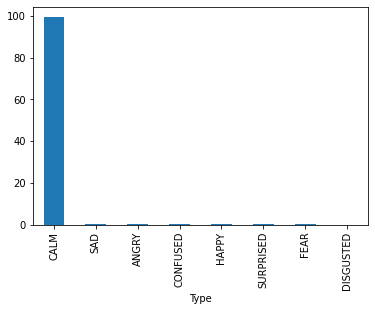

In [10]:
from secret import AWS_ACCESS_KEY, AWS_SECRET_KEY

client=boto3.client('rekognition', 
                    region_name='us-west-2',
                    aws_access_key_id=AWS_ACCESS_KEY,
                    aws_secret_access_key=AWS_SECRET_KEY
)

with open('./img/iespic.jpeg','rb') as f:
    response = client.recognize_celebrities(Image={'Bytes': f.read()})
pd.DataFrame(response['UnrecognizedFaces'][0]['Emotions']).set_index('Type').Confidence.plot.bar()

In [13]:
response

{'CelebrityFaces': [],
 'UnrecognizedFaces': [{'BoundingBox': {'Width': 0.3861386775970459,
    'Height': 0.3658880293369293,
    'Left': 0.2979205846786499,
    'Top': 0.18226316571235657},
   'Confidence': 99.99385070800781,
   'Landmarks': [{'Type': 'mouthLeft',
     'X': 0.41166001558303833,
     'Y': 0.4617924392223358},
    {'Type': 'eyeLeft', 'X': 0.40747493505477905, 'Y': 0.3298698663711548},
    {'Type': 'nose', 'X': 0.49969977140426636, 'Y': 0.39484962821006775},
    {'Type': 'mouthRight', 'X': 0.5646594762802124, 'Y': 0.4696613550186157},
    {'Type': 'eyeRight', 'X': 0.591668426990509, 'Y': 0.3395422399044037}],
   'Pose': {'Roll': 2.916618585586548,
    'Yaw': 1.5092723369598389,
    'Pitch': 9.721925735473633},
   'Quality': {'Brightness': 90.49933624267578,
    'Sharpness': 89.85481262207031},
   'Emotions': [{'Type': 'CALM', 'Confidence': 99.33566284179688},
    {'Type': 'SAD', 'Confidence': 0.37673279643058777},
    {'Type': 'ANGRY', 'Confidence': 0.11169449239969254},